**Thinking1: 今天讲解了时间序列预测的两种方式，实际上在数据库内建时间属性后，可以产生时序数据库，请思考什么是时序数据库？为什么时间序列数据成为增长最快的数据类型之一**

1. 时序数据库: 存放时序数据的数据库，并且需要支持时序数据的快速写入、持久化、多纬度的聚合查询等基本功能。
2. 由于最近20年数据量指数级增长，时间序列数据的应用场景也显著增加。往前看可以发掘历史趋势、规律、异常等，往后看可以对未来做出预测。

**Action1：PM2.5数据集
https://archive.ics.uci.edu/ml/datasets/Beijing%20PM2.5%20Data
预测未来北京PM2.5的值**

In [61]:
import pandas as pd
import numpy as np
from datetime import datetime

**数据加载**

In [2]:
# 解析时间数据
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
# 读取数据
raw = pd.read_csv('./pm2_5/PRSA_data_2010.1.1-2014.12.31.csv', 
                  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

In [3]:
raw.drop('No', axis=1, inplace=True)
# 列名替换
raw.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
raw.index.name = 'date'

In [12]:
# 数据处理label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
raw['wnd_dir'] = le.fit_transform(raw['wnd_dir'])

In [26]:
# 数据标准化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns_to_sacle = ['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']
raw[columns_to_sacle] = scaler.fit_transform(raw[columns_to_sacle])

**ARMA模型**

In [68]:
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

In [85]:
# 设置参数范围
ps = range(0, 5)
qs = range(0, 5)
parameters = product(ps, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARIMA(raw['pollution'],order=(param[0], 0, param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
print('最优模型: ', best_model.summary())

C:\Users\luoyh\anaconda3\envs\bi_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\luoyh\anaconda3\envs\bi_learning\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\luoyh\anaconda3\envs\bi_learning\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\luoyh\anaconda3\envs\bi_learning\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


最优模型:                                 SARIMAX Results                                
Dep. Variable:              pollution   No. Observations:                43824
Model:                 ARIMA(4, 0, 4)   Log Likelihood             -191264.612
Date:                Sun, 03 Jan 2021   AIC                         382549.224
Time:                        22:42:50   BIC                         382636.104
Sample:                    01-01-2010   HQIC                        382576.607
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.6063      4.773     20.658      0.000      89.251     107.962
ar.L1          1.8032      0.077     23.393      0.000       1.652       1.954
ar.L2          0.0633      0.196      0.322  

**用LSTM模型进行预测**

In [24]:
# 将时间序列数据转换为适用于监督学习的数据
def series_to_supervised(data, out_columns, n_in=1, n_out=1, dropnan=True):
    # 一个时间的特征
    df = pd.DataFrame(data)
    old_cols = df.columns
    
    # 存储新数据的列和列名
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{col}_(t-{i})' for col in old_cols]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i)[out_columns])
#         names += [f'{col}_(t)' for col in out_columns]
        if i == 0:
            names += [f'{col}_(t)' for col in out_columns]
        else:
            names += [f'{col}_(t+{i})' for col in out_columns]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [27]:
# 转化为可以用于LSTM监督学习的数据
def get_train_set(data_set, out_columns, timesteps_in, timesteps_out=1):
#     train_data_set = np.array(data_set)
    reframed_train_data_set = np.array(series_to_supervised(data_set, out_columns, timesteps_in, timesteps_out).values)
#     print(reframed_train_data_set)
#     print(reframed_train_data_set.shape)
    train_x, train_y = reframed_train_data_set[:, :-timesteps_out], reframed_train_data_set[:, -timesteps_out:]
    # 将数据集重构为符合LSTM要求的数据格式,即 [样本数，时间步，特征]
    train_x = train_x.reshape((train_x.shape[0], timesteps_in, -1))
    return train_x, train_y


In [23]:
# 得到训练数据
timesteps_in = 10
timesteps_out = 1
X, y = get_train_set(raw, ['pollution'], timesteps_in, timesteps_out)

In [38]:
# 生成训练集和测试集
from sklearn.model_selection import TimeSeriesSplit
# 此处的TimeSeriesSplit默认切成5份，五份(测试:训练)数据分别是：[1]:[2];[1,2]:[3];[1,2,3]:[4];[1,2,3,4]:[5]
tscv = TimeSeriesSplit()
#这里类似K-fold, 不过只取了最后一份进行训练[1,2,3,4]:[5]
for train_index, test_index in tscv.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [25]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
# hyperparameters
input_epochs = 1000
input_batch_size = 256
n_steps_in = timesteps_in          #输入时间步
n_features = X_train.shape[2]    #输入特征维度
n_steps_out = timesteps_out # 输出时间步

model = Sequential()  
# 第一层, 隐藏层神经元节点个数为128, 返回整个序列
model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(n_steps_in, n_features)))
# 第二层，隐藏层神经元节点个数为128, 只返回序列最后一个输出
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
# 第三层 因为是回归问题所以使用linear
model.add(Dense(n_steps_out, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
# LSTM训练 input_epochs次数
res = model.fit(X_train, y_train, epochs=input_epochs, batch_size=input_batch_size, verbose=2, shuffle=False)
# 模型预测
test_predict = model.predict(X_test)


Epoch 1/1000
130/130 - 1s - loss: 15389.9482
Epoch 2/1000
130/130 - 1s - loss: 13003.4160
Epoch 3/1000
130/130 - 1s - loss: 11217.2188
Epoch 4/1000
130/130 - 1s - loss: 9787.3125
Epoch 5/1000
130/130 - 1s - loss: 8634.1943
Epoch 6/1000
130/130 - 1s - loss: 7710.3931
Epoch 7/1000
130/130 - 1s - loss: 6938.4287
Epoch 8/1000
130/130 - 1s - loss: 6279.7573
Epoch 9/1000
130/130 - 1s - loss: 5707.4072
Epoch 10/1000
130/130 - 1s - loss: 5226.2754
Epoch 11/1000
130/130 - 1s - loss: 4822.2065
Epoch 12/1000
130/130 - 1s - loss: 4436.3687
Epoch 13/1000
130/130 - 1s - loss: 4141.6333
Epoch 14/1000
130/130 - 1s - loss: 3842.5276
Epoch 15/1000
130/130 - 1s - loss: 3577.3433
Epoch 16/1000
130/130 - 1s - loss: 3363.9714
Epoch 17/1000
130/130 - 1s - loss: 3154.3037
Epoch 18/1000
130/130 - 1s - loss: 2974.6360
Epoch 19/1000
130/130 - 1s - loss: 2804.5051
Epoch 20/1000
130/130 - 1s - loss: 2674.6536
Epoch 21/1000
130/130 - 1s - loss: 2512.3071
Epoch 22/1000
130/130 - 1s - loss: 2419.2959
Epoch 23/1000
13

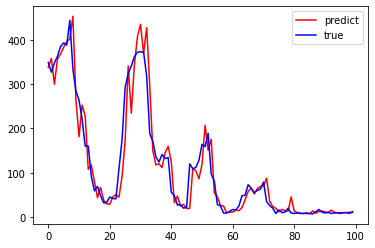

In [28]:
# 对比测试数据和预测数据:最后100个
import matplotlib.pyplot as plt
plt.plot(test_predict[-100:], 'r')
plt.plot(y_test[-100:], 'b')
plt.legend(['predict', 'true'])